# Protocol test

In [86]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
import edward_tools.fq_runner as fq_runner
from edward_tools.visualization import animate_sim_flux_qubit

import kyle_tools as kt
import matplotlib.pyplot as plt
import importlib
from edward_tools import coupled_fq_protocol_library, cfq_runner

In [87]:
I_p_1 = 2e-6       # Amp
I_p_2 = 2e-6       # Amp
I_m_1 = 7e-9       # Amp
I_m_2 = 7e-9       # Amp
R_1 = 371          # ohm
R_2 = 371          # ohm
C_1 = 4e-9         # F
C_2 = 4e-9         # F
L_1 = 1e-9         # H
L_2 = 1e-9         # H

M_12_factor = 0
M_12 = L_1 * L_2 * M_12_factor
PHI_0 = 2.067833848 * 1e-15



quick_doubler = lambda x1, x2: np.hstack([np.array([x1] * 2), np.array([x2]*2)])

I_p = quick_doubler(I_p_1, I_p_2)
I_m = quick_doubler(I_m_1, I_m_2)
R = quick_doubler(R_1, R_2)
L = quick_doubler(L_1, L_2)
C = quick_doubler(C_1, C_2)

m = np.array([1, 1/4, 1, 1/4])
nu = np.array([2, 1/2, 2, 1/2]) 
kepa = np.array([1, 1, 1, 1])


beta_1 = 2 * np.pi * L_1 * I_p_1 / PHI_0
beta_2 = 2 * np.pi * L_2 * I_p_2 / PHI_0

d_beta_1 = 2 * np.pi * L_1 * I_m_1 / PHI_0
d_beta_2 = 2 * np.pi * L_2 * I_m_2 / PHI_0



_lambda = np.sqrt(L*C)/(R*C)  * nu
_theta  = 1 / m
_eta = np.sqrt(_lambda * kepa / m)


_lambda = 1
_theta  = 1
_eta = 1

params = {}
params['N'] = 10_000
params['dt'] = 1/1_000
params['lambda'] = 1
params['beta'] = 1
params['sim_params'] = [_lambda, _theta, _eta]
params['tau'] = 40
params['target_work'] = None

In [88]:
storage_parameter_dict = {
    "t": [0, 1],
    "U0_1": [1, 1],
    "U0_2": [0, 0],    
    "gamma_1": [1, 0],
    "gamma_2": [0, 0],
    "beta_1": [0, 100],
    "beta_2": [0, 0],    
    "d_beta_1": [0, 0],
    "d_beta_2": [0, 0],    
    "phi_1_x": [0, 0],
    "phi_2_x": [0, 0],    
    "phi_1_dcx": [0, 0],
    "phi_2_dcx": [0, 0],
    "M_12": [0, 0]
}

computation_parameter_dict = {
    "t": [0, 0.5, 0.75, 1],
    "U0_1": [1, 1, 1, 1],
    "U0_2": [0, 0, 0, 0],
    "gamma_1": [0, 0, 10, 0],
    "gamma_2": [0, 0, 0, 0],
    "beta_1": [0, 0, 0, 0],
    "beta_2": [0, 0, 0, 0],
    "d_beta_1": [0, 0, 0, 0],
    "d_beta_2": [0, 0, 0, 0],
    "phi_1_x": [0, 0, 0, 0],
    "phi_2_x": [0, 0, 0, 0],
    "phi_1_dcx": [0, 0, 0, 0],
    "phi_2_dcx": [0, 0, 0, 0],
    "M_12": [0, 0]
}


In [89]:
def parameter_generator(param_dict):
    """
    To generate a list of parameter
    """
    
    return [param_dict["U0_1"], param_dict["U0_2"], param_dict["gamma_1"], \
            param_dict["gamma_2"], param_dict["beta_1"], param_dict["beta_2"], param_dict["d_beta_1"], \
            param_dict["d_beta_2"], param_dict["phi_1_x"], param_dict["phi_2_x"], param_dict["phi_1_dcx"],\
            param_dict["phi_2_dcx"], param_dict["M_12"]
           ]


In [103]:
cfq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_simple_protocol_parameter_dict = cfq_protocol_library.create_simple_protocol_parameter_dict
create_system = cfq_protocol_library.create_system
create_system_from_storage_and_computation_protocol = cfq_protocol_library.create_system_from_storage_and_computation_protocol
coupled_fq_runner = importlib.reload(cfq_runner)


In [113]:
# trial_Vstore_param = parameter_generator({
#         "U0_1": 1,     "U0_2": 1,
#         "gamma_1": 1,  "gamma_2": 1,
#         "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1,   "d_beta_2": d_beta_2,
#         "phi_x_1": 0,  "phi_x_2": 0,  "phi_xdc_1": 0,  "phi_xdc_2": 0
#     })

trial_Vstore_param = parameter_generator({
        "U0_1": 1,     "U0_2": 1,
        "gamma_1": 0,  "gamma_2": 0,
        "beta_1": 10,   "beta_2": 10,   "d_beta_1": 0,   "d_beta_2": 0,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": 0,  "phi_2_dcx": 0, 
        "M_12": 0
    })


trial_Vcomp_param = parameter_generator({
        "U0_1": 1,     "U0_2": 1,
        "gamma_1": 0,  "gamma_2": 0,
        "beta_1": 0,   "beta_2": 0,   "d_beta_1": 0,   "d_beta_2": 0,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": 0,  "phi_2_dcx": 0,
        "M_12": 0
    })

#     "U0_1": 1,        "U0_2": 1,       "gamma_1": 0,      "gamma_2": 0, 
#     "beta_1": 10,      "beta_2": 10,     "d_beta_1": 0,     "d_beta_2": 0, 
#     "phi_1_x": 0,     "phi_2_x": 0,    "phi_1_dcx": 0,    "phi_2_dcx": 10,
#     "M_12": 0

# trial_Vcomp_param = parameter_generator({
#         "U0_1": 1,     "U0_2": 0,
#         "gamma_1": 1,  "gamma_2": 0,
#         "beta_1": beta_1,   "beta_2": 0,   "d_beta_1": d_beta_1,   "d_beta_2": 0,
#         "phi_x_1": 0,  "phi_x_2": 0,  "phi_xdc_1": 0,  "phi_xdc_2": 0, "M_12": 0
#     })



realistic_param = parameter_generator({
        "U0_1": 1,     "U0_2": 1,
        "gamma_1": 12,  "gamma_2": 12,
        "beta_1": 6.2,   "beta_2": 6.2,   "d_beta_1": 0.2,   "d_beta_2": 0.2,
        "phi_1_x": 0.084,  "phi_2_x": 0.084,  "phi_1_dcx": -2.5,  "phi_2_dcx": -2.5,
        "M_12": 0
    })

t = [0, 1]

In [114]:
# to create the relevant protocols
storage_parameter_dict = create_simple_protocol_parameter_dict(trial_Vstore_param)
computation_parameter_dict = create_simple_protocol_parameter_dict(trial_Vcomp_param)
print(storage_parameter_dict)
print(computation_parameter_dict)

{'U0_1': [1, 1], 'U0_2': [1, 1], 'gamma_1': [0, 0], 'gamma_2': [0, 0], 'beta_1': [10, 10], 'beta_2': [10, 10], 'd_beta_1': [0, 0], 'd_beta_2': [0, 0], 'phi_1_x': [0, 0], 'phi_2_x': [0, 0], 'phi_1_dcx': [0, 0], 'phi_2_dcx': [0, 0], 'M_12': [0, 0], 't': [0, 1]}
{'U0_1': [1, 1], 'U0_2': [1, 1], 'gamma_1': [0, 0], 'gamma_2': [0, 0], 'beta_1': [0, 0], 'beta_2': [0, 0], 'd_beta_1': [0, 0], 'd_beta_2': [0, 0], 'phi_1_x': [0, 0], 'phi_2_x': [0, 0], 'phi_1_dcx': [0, 0], 'phi_2_dcx': [0, 0], 'M_12': [0, 0], 't': [0, 1]}


In [127]:
# protocols
storage_protocol, comp_protocol = create_system_from_storage_and_computation_protocol(computation_parameter_dict,\
                                                                                      computation_parameter_dict)

# create the eq_system and computation_system
eq_system = System(storage_protocol, coupled_fq_pot)
computation_system = System(comp_protocol, coupled_fq_pot)

# simulation parameters
_lambda = 1
_theta  = 10
_eta = 1
params = {}
params['N'] = 10_000
params['dt'] = 1/1_000
params['lambda'] = 1
params['beta'] = 1
params['sim_params'] = [_lambda, _theta, _eta]
params['tau'] = 40
params['target_work'] = None

cfqr = coupled_fq_runner.coupledFluxQubitRunner(params = params, storage_protocol= storage_protocol, \
                                computation_protocol= comp_protocol)

storage_protocol_parameter_dict is not None


In [144]:
cfqr.run_sim()


 initializing...
from fq_runner.py: system.protocol.t_i = 0.0, system.protocol.t_f = 1.0
using a lower resolution for searching a space in >3 dimensions
new resolution is 100
 found 10006 samples out of 10000from system: finish the while loop.
The as_tep is 2
The dt is 0.001
from quick_sim.py
[1, 10, 1]
from quick_sim.py
gamma: 1, theta: 10 and eta: 1.0
from quick_sim.py: system.protocol.t_f = 1.0, system.protocol.t_f = 0.0
This line is for the initializatoin of the simulation object.
number of steps: 1000, dt: 0.001

 running sim...
901 1000
902 1000
903 1000
904 1000
905 1000
906 1000
907 1000
908 1000
909 1000
910 1000
911 1000
912 1000
913 1000
914 1000
915 1000
916 1000
917 1000
918 1000
919 1000
920 1000
921 1000
922 1000
923 1000
924 1000
925 1000
926 1000
927 1000
928 1000
929 1000
930 1000
931 1000
932 1000
933 1000
934 1000
935 1000
936 1000
937 1000
938 1000
939 1000
940 1000
941 1000
942 1000
943 1000
944 1000
945 1000
946 1000
947 1000
948 1000
949 1000
950 1000
951 1000


In [145]:
all_state = cfqr.sim.output.all_state['states']
final_state = cfqr.sim.output.final_state
final_W = cfqr.sim.output.final_W
# all_W = cfqr.sim.output.all_W

In [146]:
phi_1_and_phi_dc_1_all_state = all_state[:, :, (0, 2), :]
phi_2_and_phi_dc_2_all_state = all_state[:, :, (1, 3), :]
phi_1_and_phi_2_all_state    = all_state[:, :, (0, 1), :]

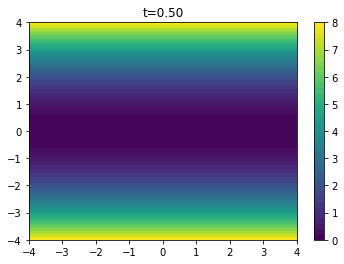

(<AxesSubplot:title={'center':'t=0.50'}>,
 <matplotlib.contour.QuadContourSet at 0x7faefd588be0>)

In [147]:
cfqr.eq_system.show_potential(0.5, axis1 = 0, axis2 = 1, surface=False)

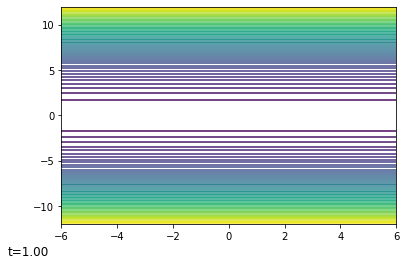

In [148]:
x_range = (-12, 12)
y_range = (-6, 6)
ani = cfqr.system.animate_protocol(axis1= 0, axis2= 1, manual_domain=[[x_range[0], y_range[0]], \
                                                                      [x_range[1], y_range[1]]], surface=False)
HTML(ani.to_jshtml(fps=50))

In [149]:
ani,_,_ = animate_sim_flux_qubit(phi_1_and_phi_2_all_state, frame_skip=10, color_by_state=True)
HTML(ani.to_jshtml(fps=10))

In [150]:
ani,_,_ = animate_sim_flux_qubit(phi_1_and_phi_dc_1_all_state, frame_skip=10, color_by_state=True)
HTML(ani.to_jshtml(fps=10))

In [151]:
ani,_,_ = animate_sim_flux_qubit(phi_2_and_phi_dc_2_all_state, frame_skip=10, color_by_state=True)
HTML(ani.to_jshtml(fps=10))

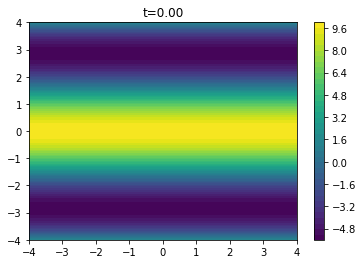

(<AxesSubplot:title={'center':'t=0.00'}>,
 <matplotlib.contour.QuadContourSet at 0x7fb01e92cb20>)

In [75]:
cfqr.system.show_potential(0, axis1 = 0, axis2 = 1)

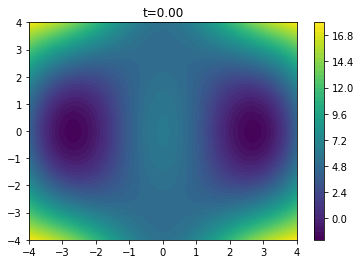

(<AxesSubplot:title={'center':'t=0.00'}>,
 <matplotlib.contour.QuadContourSet at 0x7fb01d3c5dc0>)

In [29]:
cfqr.eq_system.show_potential(0, axis1 = 1, axis2 = 3)

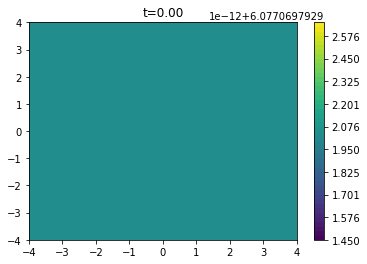

(<AxesSubplot:title={'center':'t=0.00'}>,
 <matplotlib.contour.QuadContourSet at 0x7fb01ca7f8e0>)

In [30]:
cfqr.system.show_potential(0, axis1 = 2, axis2 = 4)

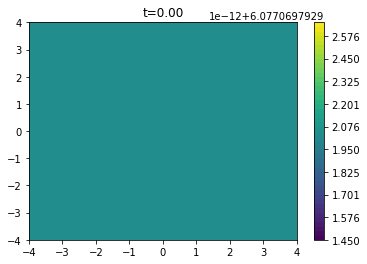

(<AxesSubplot:title={'center':'t=0.00'}>,
 <matplotlib.contour.QuadContourSet at 0x7fb2f1f39c40>)

In [31]:
cfqr.eq_system.show_potential(0, axis1 = 2, axis2 = 4)

In [ ]:
# Jarzynski term
final_W = cfqr.sim.output.final_W
plt.hist(cfqr.sim.output.final_W, bins = 100)
np.mean(np.exp(-final_W))

In [ ]:
trial_Vstore_param = parameter_generator({
        "U0_1": 1,     "U0_2": 1,
        "gamma_1": 1,  "gamma_2": 1,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1,   "d_beta_2": d_beta_2,
        "phi_x_1": 0,  "phi_x_2": 0,  "phi_xdc_1": 0,  "phi_xdc_2": 0
    })


trial_Vcomp_param = parameter_generator({
        "U0_1": 1,     "U0_2": 1,
        "gamma_1": 0,  "gamma_2": 0,
        "beta_1": 0,   "beta_2": 0,   "d_beta_1": 0,   "d_beta_2": 0,
        "phi_x_1": 0,  "phi_x_2": 0,  "phi_xdc_1": 0,  "phi_xdc_2": 0
    })

# to create the relevant protocols
storage_parameter_dict = create_simple_protocol_parameter_dict(trial_Vstore_param)
computation_parameter_dict = create_simple_protocol_parameter_dict(trial_Vcomp_param)


In [ ]:
# protocols
storage_protocol, comp_protocol = create_system(storage_parameter_dict, computation_parameter_dict)

# create the eq_system and computation_system
eq_system = System(storage_protocol, coupled_fq_pot)
computation_system = System(comp_protocol, coupled_fq_pot)

# simulation parameters
_lambda = 1
_theta  = 1
_eta = 1
params = {}
params['N'] = 10_000
params['dt'] = 1/1_000
params['lambda'] = 1
params['beta'] = 1
params['sim_params'] = [_lambda, _theta, _eta]
params['tau'] = 40
params['target_work'] = None

cfqr = coupled_fq_runner.coupledFluxQubitRunner(params = params, storage_protocol= storage_protocol, \
                                computation_protocol= comp_protocol)

In [ ]:
cfqr.run_sim()

In [ ]:
all_state = cfqr.sim.output.all_state['states']
final_state = cfqr.sim.output.final_state
final_W = cfqr.sim.output.final_W
# all_W = cfqr.sim.output.all_W

In [ ]:
phi_1_and_phi_dc_1_all_state = all_state[:, :, (0, 2), :]
phi_2_and_phi_dc_2_all_state = all_state[:, :, (1, 3), :]

In [ ]:
ani,_,_ = animate_sim_flux_qubit(phi_1_and_phi_dc_1_all_state, frame_skip=10, color_by_state=True)
HTML(ani.to_jshtml(fps=10))

In [ ]:
ani,_,_ = animate_sim_flux_qubit(phi_2_and_phi_dc_2_all_state, frame_skip=10, color_by_state=True)
HTML(ani.to_jshtml(fps=10))